In [1]:
import numpy as np
import scipy.io as scio # load mat file
from scipy.signal import welch, filtfilt
from scipy.interpolate import interp1d

from PSO import *  # demo PSO codes!

import matplotlib.pyplot as plt


G = 6.67430e-11  # 万有引力常数, m^3 kg^-1 s^-2
c = 2.998e8  # 光速, m/s
M_sun = 1.989e30  # 太阳质量, kg
pc = 3.086e16  # pc到m的转换

/home/ywq/anaconda3/envs/PSOlinux/lib/python3.12/site-packages/pycbc/types/array.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal as _lal
PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1


In [2]:
# load data
TrainingData = scio.loadmat('noise_pycbc.mat') # only noise    
analysisData = scio.loadmat('data_pycbc.mat') # noise + signal
# analysisData = scio.loadmat('TrainingData.mat') # only noise to check

## Preparing
# dataY = analysisData['dataVec'][0] # (2048,)
dataY = analysisData['data'][0]
# dataY = analysisData['trainData'][0] # (2048,)1
# Data length
nSamples = dataY.size # 2048
# Sampling frequency
# Fs = analysisData['sampFreq'][0,0] # 1024
Fs = analysisData['samples'][0]
# Fs = 1024

# Search range of phase coefficients
"""
        m1,m2,f_lower,sample_rate,MLZ,y
"""
rmin = [1,1,100,10,1e3 * M_sun,0]
rmax = [100,100,100 ,1e4,1e8*M_sun,0.5]

# Noise realization: PSD estimated from TrainingData
dt = 1/Fs
# t = np.arange(0, nSamples*dt, dt) # (2048,)
# 实际上这是个传递参数，也就是说我们要事先知道时间为多少合适
t = np.linspace(-40,0,nSamples)
T = nSamples/Fs
df = 1/T
Nyq = Fs/2 # Nyquist frequency
[f, pxx] = welch(TrainingData['noise'][0], fs=Fs, 
                 window='hamming', nperseg=Fs/2, 
                 noverlap=None, nfft=None, 
                 detrend=False) 
# Why 'detrend=False'? 
# See https://github.com/scipy/scipy/issues/8045#issuecomment-337319294
# or https://iphysresearch.github.io/blog/post/signal_processing/spectral_analysis_scipy/

# Smooth the PSD estimate
smthOrdr = 10
b = np.ones(smthOrdr)/smthOrdr
pxxSmth = filtfilt(b,1,pxx)
# PSD must be supplied at DFT frequencies.
kNyq = np.floor(nSamples/2) + 1
posFreq = np.arange(0, kNyq)*Fs/nSamples
psdPosFreq = interp1d(f,pxxSmth)(posFreq)
print(dataY.size)

8294


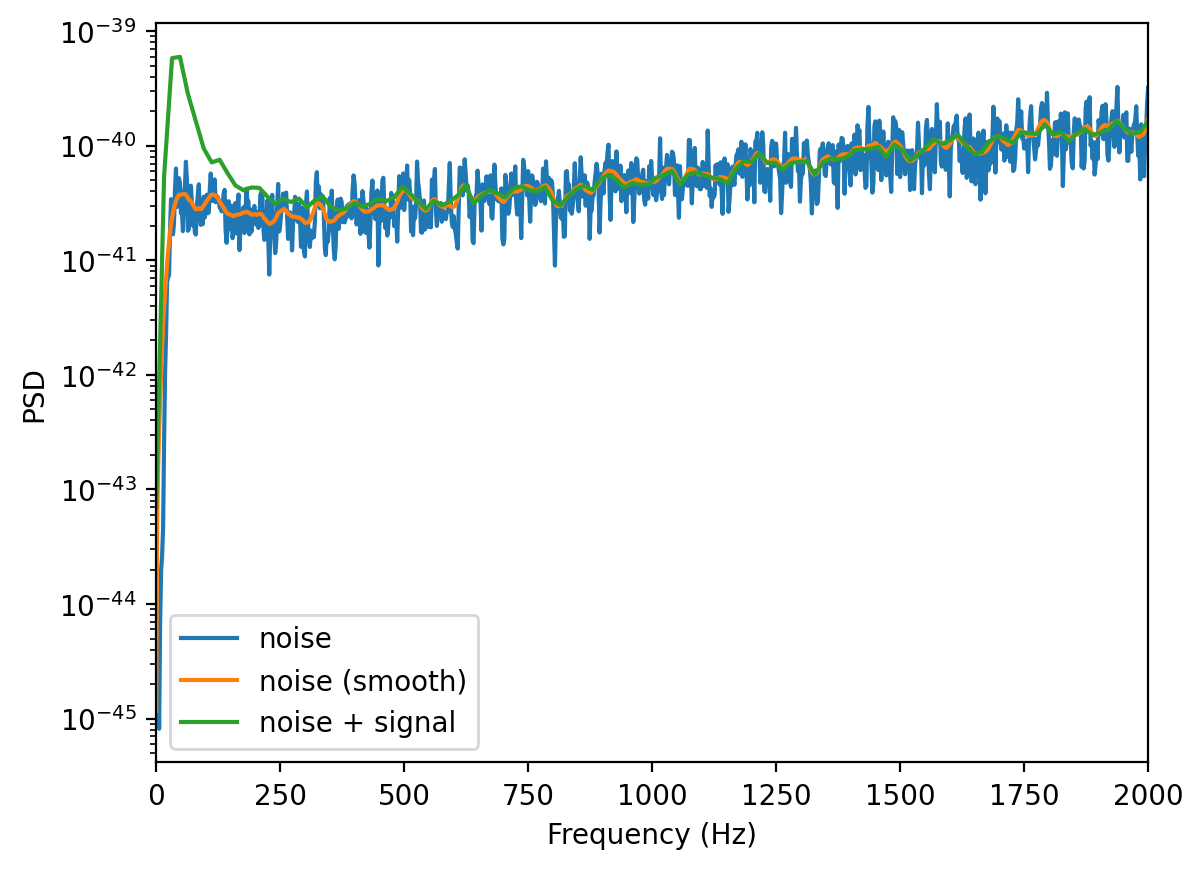

In [3]:
# Plot PSDs for the noise and noise + signal.
plt.figure(dpi=200)
plt.plot(f,pxx, label='noise')
plt.plot(f,pxxSmth, label='noise (smooth)')
[f, pxxY] = welch(dataY, fs=Fs, 
                 window='hamming', nperseg=256, 
                 noverlap=None, nfft=None, 
                 detrend=False)
plt.plot(np.abs(f),pxxY, label='noise + signal')
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD')
plt.yscale('log')
plt.xlim(0,2000)
plt.legend()
plt.savefig('output_psd.png', dpi=200)
plt.show()

In [4]:
# Number of independent PSO runs
nRuns = 8

In [5]:
## PSO
# Input parameters for CRCBQCHRPPSO
inParams = {
    'dataX': t,
    'dataY': dataY,
    # 'dataXSq': t**2,
    # 'dataXCb': t**3,
    # 'psdPosFreq': psdPosFreq,
    'sampFreq': Fs,
    'rmin': rmin,
    'rmax': rmax,
}
# CRCBQCHRPPSOPSD runs PSO on the CRCBQCHRPFITFUNC fitness function. As an
# illustration of usage, we change one of the PSO parameters from itsw
# default value.
outResults, outStruct = crcbqcpsopsd(inParams, {'maxSteps': 2000}, nRuns)

  0%|          | 0/2000 [00:00<?, ?it/s]

/home/ywq/PSO_change/pycbc_test/PSO.py:429: RuntimeWarning: divide by zero encountered in divide
  innProd = np.sum((1/dataLen) * (fftX / psdVec4Norm)*fftY.conj())
/home/ywq/PSO_change/pycbc_test/PSO.py:429: RuntimeWarning: invalid value encountered in divide
  innProd = np.sum((1/dataLen) * (fftX / psdVec4Norm)*fftY.conj())
/home/ywq/PSO_change/pycbc_test/PSO.py:429: RuntimeWarning: invalid value encountered in multiply
  innProd = np.sum((1/dataLen) * (fftX / psdVec4Norm)*fftY.conj())
  0%|          | 0/2000 [00:00<?, ?it/s]


tlen:1652
hp.duration:0.30293122646323484
delta_f:3.30107929669431
knyq:827.0,psd:827
nsamples:1652,yVex:1652
nSamples=1652, kNyq=827.0, negFStrt=1
莫非是这里？
nsamples:8294,yVex:1652


AssertionError: Vectors must be of the same length

In [ ]:
## Plots
fig = plt.figure(dpi=200)
ax = fig.add_subplot(111)
a=ax.scatter(t, dataY, marker='.', s=5, #label='analysisData'
             )
a.set_label('analysisData')
for lpruns in range(nRuns):
    b,=ax.plot(t, outResults['allRunsOutput'][lpruns]['estSig'],
             color=[51/255,255/255,153/255], lw=.4*2)
b.set_label('estSig')
c,=ax.plot(t, outResults['bestSig'], #label='BestSig',
         'red',lw=.2*2)
c.set_label('BestSig')
plt.legend()
plt.savefig('output_sig.png', dpi=200)
plt.show()
# print(outResults['allRunsOutput'][lpruns]['estSig'])

In [ ]:
# Print estimated parameters
print('Estimated parameters:')
print('bestFitness = {:.4f}'.format(outResults['bestFitness']))
print('m1 = {:.4e}'.format(outResults['m1']))
print('m2 = {:.4e}'.format(outResults['m2'])) 
print('f_lower = {:.4f}'.format(outResults['f_lower']))
print('sample_rate = {:.4f}'.format(outResults['sample_rate']))
print('mlz = {:.4e}'.format(outResults['mlz']))
print('y = {:.4f}'.format(outResults['y']))

for lpruns in range(nRuns):
    print('\nRun No.{}:'.format(lpruns+1))
    print('bestFitness={:.2f}'.format(outStruct[lpruns]['bestFitness']))
    print('m1 = {:.4e}'.format(outResults['allRunsOutput'][lpruns]['m1']))
    print('m2 = {:.4e}'.format(outResults['allRunsOutput'][lpruns]['m2']))
    print('f_lower = {:.4f}'.format(outResults['allRunsOutput'][lpruns]['f_lower']))
    print('sample_rate = {:.4f}'.format(outResults['allRunsOutput'][lpruns]['sample_rate']))
    print('mlz = {:.4e}'.format(outResults['allRunsOutput'][lpruns]['mlz']))
    print('y = {:.4f}'.format(outResults['allRunsOutput'][lpruns]['y']))

# Save
np.save('output_results',outResults)
np.save('output_struct',outStruct)

In [ ]:
fig = plt.figure(dpi=200)
plt.plot(t, outResults['bestSig'], #label='BestSig',
         'blue',lw=.2*2)
plt.show()